## Overview

In this Kaggle notebook, we aim to develop machine learning models for predicting the age and gender of individuals based on chest X-ray images. The dataset used for training and evaluation consists of X-ray images along with corresponding age and gender labels.

## Objectives

1. **Age Prediction:** Utilizing a deep learning model to predict the age of individuals from chest X-ray images.

2. **Gender Prediction:** Employing another model to predict the gender (male/female) of individuals based on the same set of X-ray images.

## Dataset

The dataset is sourced from the "SPR X-ray Age and Gender Dataset" on Kaggle. It includes a collection of chest X-ray images, each associated with age and gender labels.

## Workflow

1. **Data Preprocessing:** Loading and preprocessing the dataset, splitting it into training and testing sets.

2. **Model Development:**
   - Building a convolutional neural network (CNN) for age prediction.
   - Constructing another CNN for gender prediction.

3. **Training Models:** Training the models on the training dataset and fine-tuning hyperparameters.

4. **Evaluation:** Assessing the performance of both models on the test dataset using relevant evaluation metrics.

5. **Prediction:** Demonstrating the use of trained models to make predictions on new chest X-ray images.

Let's dive into the code and explore the fascinating world of medical image analysis!

## Initial Setup and Imports

The initial section of the notebook involves setting up the environment and importing necessary libraries. Key components include:

- **File Operations:** Importing modules such as `os` and `shutil` for handling file operations.
- **Data Manipulation:** Utilizing `numpy` and `pandas` for efficient data manipulation.
- **Visualization:** Using `seaborn` and `matplotlib.pyplot` for visualizing data distributions and results.
- **Machine Learning Framework:** Incorporating the powerful `tensorflow` library for building and training machine learning models.
- **Model Evaluation:** Importing functions from `sklearn` for model evaluation, including class weight computation.

Additionally, the notebook suppresses unnecessary warnings using `warnings.filterwarnings('ignore')`.

### Constants and Parameters

- `BATCH_SIZE`: Specifies the batch size for training the models.
- `IMG_HEIGHT` and `IMG_WIDTH`: Define the dimensions to which the input images will be resized.
- `EPOCHS`: Sets the number of training epochs for the models.
- `class_names`: A dictionary mapping gender class indices (0 and 1) to their corresponding labels ('Female' and 'Male').

These initializations provide the foundational elements for subsequent data processing and model development in the notebook.

In [1]:
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=200
class_names = {0:'Female', 1:'Male'}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading and Merging Data

The code snippet includes the following steps:

- **Age Data Loading:** Reading the age information from the 'train_age.csv' file located at '/kaggle/input/spr-x-ray-age-and-gender-dataset/' using `pd.read_csv()` and storing it in the `age_data` DataFrame.

- **Gender Data Loading:** Similarly, reading the gender information from the 'train_gender.csv' file located at the same directory and storing it in the `gender_data` DataFrame.

- **Merging DataFrames:** Combining the age and gender information using the 'imageId' column as the common key. The result is stored in the `merged_df` DataFrame.

In [2]:
age_data = pd.read_csv('/kaggle/input/spr-x-ray-age-and-gender-dataset/train_age.csv')
gender_data = pd.read_csv('/kaggle/input/spr-x-ray-age-and-gender-dataset/train_gender.csv')
merged_df = pd.merge(age_data, gender_data, on='imageId')
merged_df

,imageId,age,gender
0,0,89.0,0
1,1,72.0,0
2,2,25.0,1
3,3,68.0,1
4,4,37.0,0
...,...,...,...
10697,10697,79.0,0
10698,10698,67.0,0
10699,10699,66.0,1
10700,10700,78.0,0


## Data Folder Structure and Splitting

The code snippet manages the organization of image files into training and testing folders. Here's a breakdown:

1.  Image Paths Creation:

*   `image_folder`: Specifies the base directory containing the X-ray images.
*   `merged_df['image_path']`: Creates a new column in the DataFrame (`image_path`) by combining the base directory, image filename, and extension.

1.  Data Splitting:

*   `train_test_split`: Splits the merged DataFrame into training and testing sets using 80-20 ratio. The split is based on the 'imageId' column to ensure consistency.

1.  Folder Creation:

*   `train_folder` and `test_folder`: Define the paths for the training and testing folders, respectively.
*   `os.makedirs`: Ensures the existence of the specified folders. If they don't exist, they are created.

1.  Data Copying:

*   A loop iterates through the rows of the training set (`train_df`), copying images from their original paths to the `train_folder` with consistent filenames.
*   A similar process is followed for the testing set (`test_df`) and `test_folder`.

This structure prepares the data for model training and evaluation by organizing images into separate folders for training and testing.

In [3]:
image_folder = '/kaggle/input/spr-x-ray-age-and-gender-dataset/kaggle/kaggle/train/'
merged_df['image_path'] = merged_df['imageId'].apply(lambda x: os.path.join(image_folder, f'{x:06d}.png'))

train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, shuffle=True)

train_folder = '/kaggle/working/train/'
test_folder = '/kaggle/working/test/'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for index, row in train_df.iterrows():
    image_path = row['image_path']
    destination_path = os.path.join(train_folder, f"{row['imageId']:06d}.png")
    shutil.copyfile(image_path, destination_path)

for index, row in test_df.iterrows():
    image_path = row['image_path']
    destination_path = os.path.join(test_folder, f"{row['imageId']:06d}.png")
    shutil.copyfile(image_path, destination_path)

## Dataframe Organization

These codes organize the training and testing DataFrames (`train_df` and `test_df`) by sorting them based on the 'imageId' column in ascending order. The 'image\_path' column is then dropped, and the index is reset for better consistency and readability.

In [4]:
train_df = train_df.sort_values(by='imageId', ascending=True)
train_df = train_df.reset_index(drop=True)
train_df = train_df.drop('image_path', axis=1)
train_df

,imageId,age,gender
0,1,72.0,0
1,2,25.0,1
2,4,37.0,0
3,5,62.0,1
4,6,52.0,1
...,...,...,...
8556,10694,78.0,0
8557,10696,68.0,1
8558,10697,79.0,0
8559,10698,67.0,0


In [5]:
test_df = test_df.sort_values(by='imageId', ascending=True)
test_df = test_df.reset_index(drop=True)
test_df = test_df.drop('image_path', axis=1)
test_df

,imageId,age,gender
0,0,89.0,0
1,3,68.0,1
2,8,83.0,0
3,10,82.0,1
4,14,28.0,1
...,...,...,...
2136,10678,67.0,0
2137,10691,69.0,1
2138,10695,79.0,1
2139,10700,78.0,0


## Visualization

### Distribution of Genders in the Dataset

The code utilizes Seaborn, a powerful data visualization library, to create a countplot depicting the distribution of genders in the training dataset.

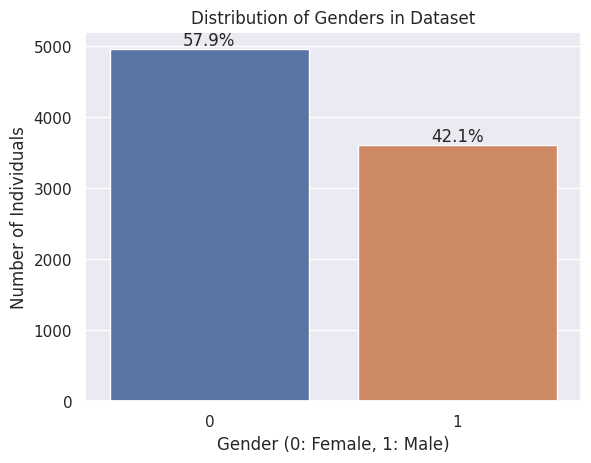

In [6]:
sns.set(style="darkgrid")
ax = sns.countplot(x="gender", data=train_df)

plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Genders in Dataset")

total = len(train_df['gender'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show();

### Distribution of Age in the Dataset

The code employs Seaborn to create a histogram with a kernel density estimate (KDE) to illustrate the distribution of ages in the training dataset.

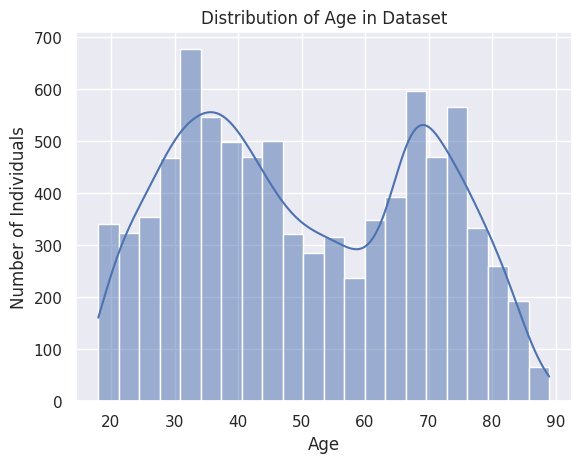

In [7]:
sns.histplot(data=train_df, x="age", kde=True)
plt.xlabel("Age")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Age in Dataset")
plt.show();

## Dataset Image Counts

Calculating the number of images in the training and test datasets:

In [8]:
train_data_dir = pathlib.Path(train_folder).with_suffix('')
test_data_dir = pathlib.Path(test_folder).with_suffix('')
train_image_count = len(list(train_data_dir.glob('*.png')))
test_image_count = len(list(test_data_dir.glob('*.png')))
print(f'There are {train_image_count} images in training dataset.')
print(f'There are {test_image_count} images in test dataset.')

There are 8561 images in training dataset.
There are 2141 images in test dataset.


These counts provide essential information about the dataset size, aiding in understanding the volume of data available for training and testing machine learning models.

## Image Loading and Shape

This code snippet involves loading an image using TensorFlow's Keras utility function. The training variable holds a list of image file paths in the training dataset directory. The second line loads and displays the first image in the list using the load_img function.

This process provides a quick visual inspection of an image from the training dataset, aiding in understanding the dataset's content and quality.

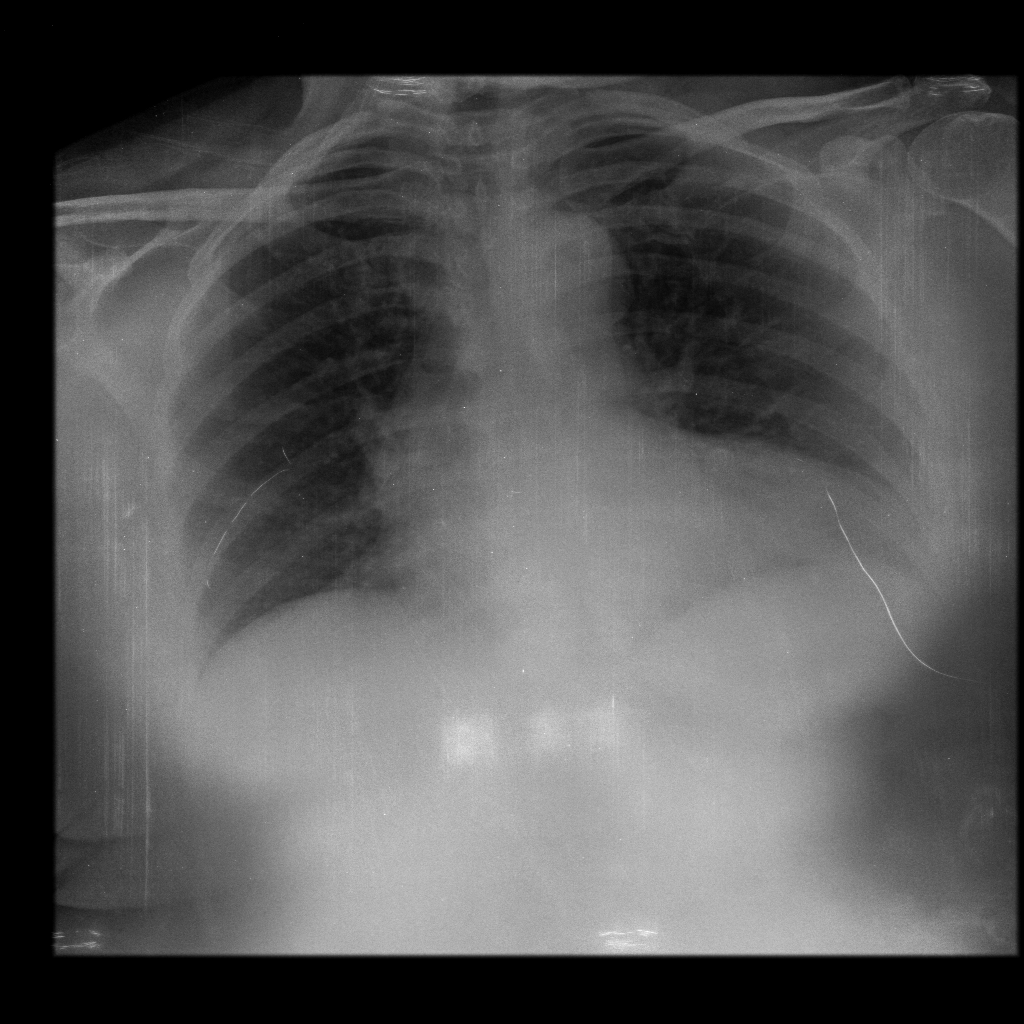

In [9]:
training = list(train_data_dir.glob('*'))
tf.keras.utils.load_img(str(training[0]))

The code below defines a function, shape_of_xray_image, which takes a category (list of image paths) and an index as parameters. It reads and decodes a JPEG image from the specified path, determines its shape using TensorFlow, and prints the result:

In [10]:
def shape_of_xray_image(category, index):
    image_path = str(category[index])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    shape = tf.shape(image)
    print(f"Shape of the image: {shape}")

shape_of_xray_image(training, 0)

Shape of the image: [1024 1024    3]


## Age Dataset Creation

In [11]:
train_ds_age = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['age']),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds_age = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['age']),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 8561 files belonging to 72 classes.
Using 6849 files for training.
Found 8561 files belonging to 72 classes.
Using 1712 files for validation.


In [12]:
train_ds_gender = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['gender']),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds_gender = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels=list(train_df['gender']),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 8561 files belonging to 2 classes.
Using 6849 files for training.
Found 8561 files belonging to 2 classes.
Using 1712 files for validation.


## Class Weight Calculation for Gender Dataset

In [13]:
class_labels = np.array([label for images, labels in train_ds_gender for label in labels.numpy()])
class_counts = np.unique(class_labels, return_counts=True)[1]
class_weights = compute_class_weight("balanced", classes=np.unique(class_labels), y=class_labels)

for class_name, weight in zip(train_ds_gender.class_names, class_weights):
    print(f"Class '{class_name}': Weight {weight:.4f}")

Class '0': Weight 0.8635
Class '1': Weight 1.1878


In [14]:
class_weights = {0:class_weights[0], 1:class_weights[1]}
class_weights

{0: 0.863464447806354, 1: 1.1878251821019772}

These weights are useful for handling class imbalance during the training of a machine learning model for gender prediction.

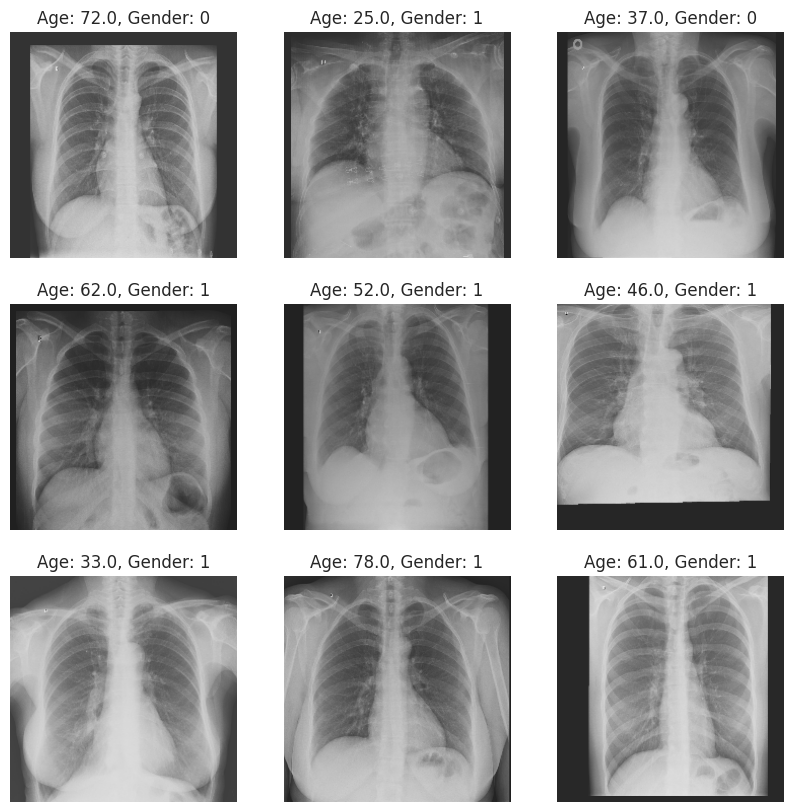

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_gender.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Age: {train_df['age'].iloc[i]}, Gender: {train_df['gender'].iloc[i]}")
    plt.axis("off")
plt.show()

## Batch Shape Inspection

In [16]:
for image_batch, labels_batch in train_ds_gender:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Data Pipeline Optimization

The code utilizes TensorFlow's cache and prefetch functions to optimize the data pipeline for training and validation datasets. Caching stores elements in memory for faster retrieval, while prefetching overlaps the data loading and model execution to improve overall performance. The `AUTOTUNE` parameter dynamically adjusts the number of parallel calls for optimal resource utilization. This optimization enhances the efficiency of the data input pipeline during model training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_age = train_ds_age.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_gender = train_ds_gender.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_age = val_ds_age.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_gender = val_ds_gender.cache().prefetch(buffer_size=AUTOTUNE)

## Image Augmentation Visualization

This code block defines an image augmentation model using TensorFlow's Keras. It randomly rotates and zooms images. The subsequent loop applies this augmentation to a batch of images from the age training dataset and visualizes the augmented images in a 3x3 grid, providing a glimpse of the data transformations applied during the training process.

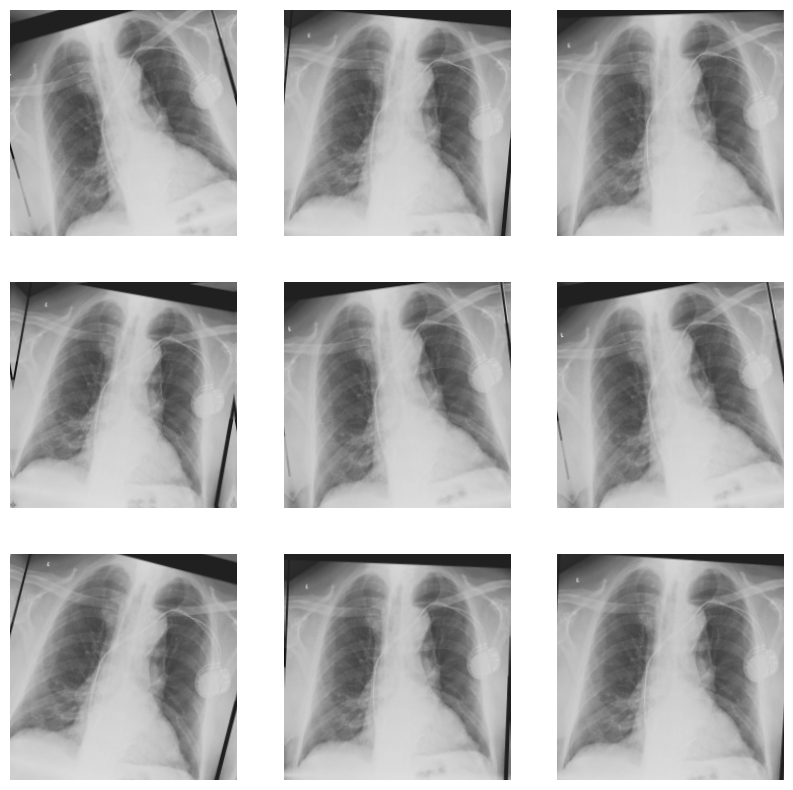

In [19]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
layer = tf.keras.layers.RandomRotation(0.05)(image_input)
output = tf.keras.layers.RandomZoom(0.05)(layer)
image_input_and_augmentation = tf.keras.Model(inputs = [image_input], outputs = [output])

plt.figure(figsize=(10, 10))
for images, _ in train_ds_age.take(1):
  for i in range(9):
    augmented_images = image_input_and_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
def convolutional_block(filter, layer):
    layer = tf.keras.layers.Conv2D(filter, (3,3), activation='relu')(layer)
    layer = tf.keras.layers.MaxPooling2D(2,2)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(0.20)(layer)
    return layer

def dense_block(nodes, layer):
    layer = tf.keras.layers.Dense(nodes, activation='relu')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(0.25)(layer)
    return layer

## Age Prediction Model Architecture

This code defines the architecture of an age prediction model using TensorFlow's Keras API. The model includes layers for data normalization, random rotation and zoom augmentation, convolutional blocks, global average pooling, dense blocks, and a final output layer. The model is compiled with a mean squared error loss function, and additional metrics for evaluation. Early stopping and learning rate scheduling callbacks are incorporated for model training. The `summary()` function provides a summary of the model's architecture.

In [21]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
normalized_image = tf.keras.layers.BatchNormalization()(image_input)
layer = tf.keras.layers.RandomRotation(0.05)(normalized_image)
augmented_image = tf.keras.layers.RandomZoom(0.05)(layer)
c1 = convolutional_block(32, augmented_image)
c2 = convolutional_block(64, c1)
c3 = convolutional_block(128, c2)
c4 = convolutional_block(128, c3)
c5 = convolutional_block(128, c4)
gap2d = tf.keras.layers.GlobalAveragePooling2D()(c5)
flattened = tf.keras.layers.Flatten()(gap2d)
d1 = dense_block(128, flattened)
d2 = dense_block(64, d1)
d3 = dense_block(32, d2)
output = tf.keras.layers.Dense(1, activation='relu')(d3)

age_model = tf.keras.Model(inputs=[image_input], outputs=[output])

age_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tf.metrics.MeanSquaredError())
              
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 5, factor = 0.1, verbose = 1, min_lr = 5e-10)

age_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0   

## Gender Prediction Model Architecture

This code defines the architecture of a gender prediction model using TensorFlow's Keras API. The model includes layers for data normalization, random rotation and zoom augmentation, convolutional blocks, global average pooling, dense blocks, and a final output layer with sigmoid activation for binary classification. The model is compiled with binary crossentropy loss and additional metrics for evaluation. The `summary()` function provides a summary() of the model's architecture.

In [22]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
normalized_image = tf.keras.layers.BatchNormalization()(image_input)
layer = tf.keras.layers.RandomRotation(0.05)(normalized_image)
augmented_image = tf.keras.layers.RandomZoom(0.05)(layer)
c1 = convolutional_block(32, augmented_image)
c2 = convolutional_block(64, c1)
c3 = convolutional_block(128, c2)
c4 = convolutional_block(128, c3)
c5 = convolutional_block(128, c4)
gap2d = tf.keras.layers.GlobalAveragePooling2D()(c5)
flattened = tf.keras.layers.Flatten()(gap2d)
d1 = dense_block(128, flattened)
d2 = dense_block(64, d1)
d3 = dense_block(32, d2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(d3)

gender_model = tf.keras.Model(inputs=[image_input], outputs=[output])

gender_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

gender_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_9 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 random_rotation_3 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0   

## Age Prediction Model Training

This code block trains the age prediction model using the training dataset (`train_ds_age`). The training process includes validation on the validation dataset (`val_ds_age`) and is run for a specified number of epochs (`EPOCHS`). Callbacks, such as early stopping and learning rate scheduler, are used to monitor and improve the training process.

In [23]:
age_history = age_model.fit(train_ds_age,
                            validation_data=val_ds_age,
                            epochs=EPOCHS,
                            callbacks=[early_stopping, lr_sch])

Epoch 1/200


2024-02-01 12:16:55.467597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 48s 175ms/step - loss: 2410.2434 - mean_squared_error: 2410.2434 - val_loss: 1219.1921 - val_mean_squared_error: 1219.1921 - lr: 0.0010
Epoch 2/200
215/215 [==============================] - 24s 109ms/step - loss: 1705.7021 - mean_squared_error: 1705.7021 - val_loss: 704.0002 - val_mean_squared_error: 704.0002 - lr: 0.0010
Epoch 3/200
215/215 [==============================] - 23s 109ms/step - loss: 1145.0557 - mean_squared_error: 1145.0557 - val_loss: 538.7896 - val_mean_squared_error: 538.7896 - lr: 0.0010
Epoch 4/200
215/215 [==============================] - 23s 108ms/step - loss: 808.0797 - mean_squared_error: 808.0797 - val_loss: 540.8644 - val_mean_squared_error: 540.8644 - lr: 0.0010
Epoch 5/200
215/215 [==============================] - 23s 108ms/step - loss: 623.8913 - mean_squared_error: 623.8913 - val_loss: 430.9035 - val_mean_squared_error: 430.9035 - lr: 0.0010
Epoch 6/200
215/215 [==============================] - 23s 108ms/step

## Age Prediction Model Training Visualization

This code block generates a visual representation of the training history for the age prediction model. The left subplot shows the training and validation loss over epochs, while the right subplot displays the mean squared error and its validation counterpart. The visualization helps in assessing the model's performance during training.

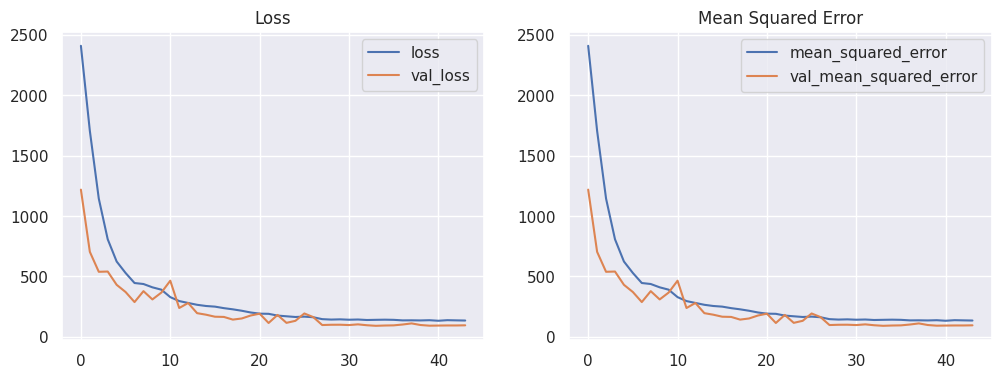

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame(age_history.history).loc[:, ['loss', 'val_loss']].plot(ax=axs[0], title="Loss")
pd.DataFrame(age_history.history).loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot(ax=axs[1], title="Mean Squared Error");

## Gender Prediction Model Training

This code block trains the gender prediction model using the training dataset (`train_ds_gender`). The training process includes validation on the validation dataset (`val_ds_gender`) and is run for a specified number of epochs (`EPOCHS`). Class weights are considered to address imbalances in the dataset, and callbacks, such as early stopping and learning rate scheduler, are employed to monitor and enhance the training process.

In [25]:
gender_history = gender_model.fit(train_ds_gender,
                                  validation_data=val_ds_gender,
                                  epochs=EPOCHS,
                                  class_weight=class_weights,
                                  callbacks=[early_stopping, lr_sch])

Epoch 1/200


2024-02-01 12:37:55.034138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 98s 172ms/step - loss: 0.6828 - binary_accuracy: 0.6326 - precision: 0.5557 - recall: 0.6351 - val_loss: 1.9067 - val_binary_accuracy: 0.4229 - val_precision: 0.4229 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/200
215/215 [==============================] - 24s 111ms/step - loss: 0.5378 - binary_accuracy: 0.7384 - precision: 0.6704 - recall: 0.7444 - val_loss: 5.0293 - val_binary_accuracy: 0.4229 - val_precision: 0.4229 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/200
215/215 [==============================] - 24s 112ms/step - loss: 0.4486 - binary_accuracy: 0.7975 - precision: 0.7416 - recall: 0.7964 - val_loss: 2.2274 - val_binary_accuracy: 0.4352 - val_precision: 0.4281 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/200
215/215 [==============================] - 24s 112ms/step - loss: 0.4019 - binary_accuracy: 0.8206 - precision: 0.7609 - recall: 0.8366 - val_loss: 0.5910 - val_binary_accuracy: 0.7150 - val_precision: 0.5993 - val_recall: 0.9834 - lr:

## Gender Prediction Model Training Visualization

This code block generates a visual representation of the training history for the gender prediction model. The left subplot shows the training and validation loss over epochs, while the right subplot displays binary accuracy and its validation counterpart. The visualization helps in assessing the model's performance during training.

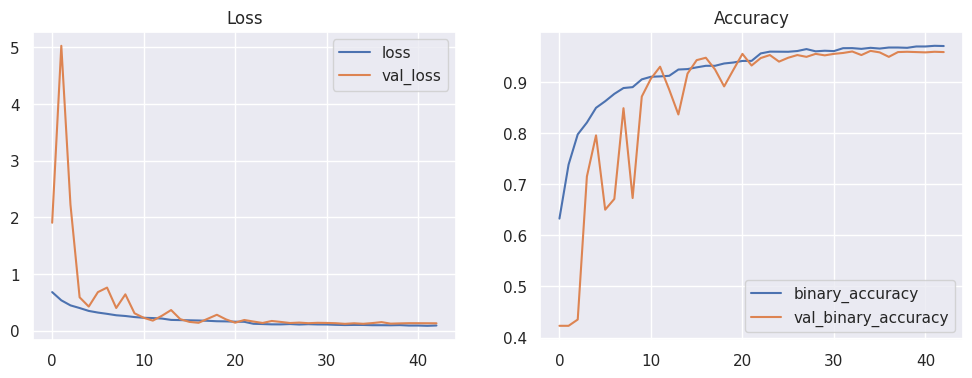

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
pd.DataFrame(gender_history.history).loc[:, ['loss', 'val_loss']].plot(ax=axs[0], title="Loss")
pd.DataFrame(gender_history.history).loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=axs[1], title="Accuracy");

## Test Datasets for Age and Gender Models

In [31]:
test_ds_age = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  labels=list(test_df['age']),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

test_ds_gender = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  labels=list(test_df['gender']),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2141 files belonging to 72 classes.
Found 2141 files belonging to 2 classes.


## Evaluation of Age Prediction Model on Test Dataset

In [32]:
age_model.evaluate(test_ds_age)

67/67 [==============================] - 16s 217ms/step - loss: 89.5477 - mean_squared_error: 89.5477


[89.54767608642578, 89.54767608642578]

## Evaluation of Gender Prediction Model on Test Dataset

In [33]:
gender_model.evaluate(test_ds_gender)

67/67 [==============================] - 16s 216ms/step - loss: 0.1321 - binary_accuracy: 0.9598 - precision: 0.9301 - recall: 0.9763


[0.13210956752300262,
 0.9598318338394165,
 0.9301075339317322,
 0.9762979745864868]

## Prediction of Age and Gender for an Example Image

In [37]:
def predict_image(example):
    img = tf.keras.utils.load_img(example, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    age_prediction = age_model.predict(img_array)
    age_prediction = int(age_prediction)
    gender_prediction = gender_model.predict(img_array)
    gender_prediction = 0 if gender_prediction < 0.50 else 1
    predicted_gender = class_names[gender_prediction]

    print(f"This image most likely belongs to {age_prediction} old {predicted_gender}")
    
predict_image('/kaggle/working/test/000000.png')

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to 67 old Female


## Save Trained Models

The code saves the trained models (`gender_model` and `age_model`) into the files 'gender_model.h5' and 'age_model.h5', respectively. This is a common practice to store the models after training, allowing for later use or deployment without the need to retrain.

In [38]:
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')

## Conclusion

In this notebook, we developed a comprehensive deep learning solution for age and gender prediction using chest X-ray images. The process involved data preprocessing, exploration, and augmentation, followed by the creation and training of two distinct models for age and gender prediction. Leveraging convolutional and dense neural network architectures, the models were trained on a dataset with a balanced representation of genders, and class weights were applied to address the class imbalance.

The training progress, including loss and accuracy metrics, was visualized, and the models were evaluated on a separate test dataset. The evaluation results demonstrated the effectiveness of the models in predicting age and gender from chest X-ray images.

Finally, we showcased how to utilize the trained models for making predictions on new images. The models were saved for future use or deployment in real-world applications.

This notebook serves as a valuable resource for medical practitioners and AI enthusiasts interested in leveraging deep learning for image-based healthcare applications.

Thanks for reading.